# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). **Make sure you explain your decisions whenever necessary.** 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

Initial thoughts: In this problem, we want to predict whether customers will cancel their hotel reservation based on the 18 features in the dataset. Personally, I think lead_time and avgpriceper_room might have the most impact on their decision, but I'll test to see if it's true. All features are in numeric forms, but some of them are actually categorical or binary features.

In [2]:
df = pd.read_csv("train__dataset.csv")
df

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0                 2               0                     1                  4   
1                 2               1                     0                  2   
2                 1               0                     1                  5   
3                 1               0                     2                  4   
4                 2               0                     0                  4   
...             ...             ...                   ...                ...   
18132             1               0                     0                  2   
18133             2               0                     0                  3   
18134             2               0                     0                  1   
18135             2               0                     0                  3   
18136             1               0                     1                  1   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0                      0                           0                   0   
1                      0                           0                   0   
2                      0                           0                   0   
3                      0                           0                   0   
4                      1                           0                   0   
...                  ...                         ...                 ...   
18132                  0                           0                   0   
18133                  0                           0                   0   
18134                  0                           0                   0   
18135                  0                           0                   0   
18136                  0                           0                   0   

       lead_time  arrival_year  arrival_month  arrival_date  \
0            118          2017             12            28   
1             17          2018              4            14   
2            349          2018             10             4   
3             69          2018              6            12   
4             11          2018              1            20   
...          ...           ...            ...           ...   
18132        103          2018              4            19   
18133        129          2018              8            10   
18134         90          2018              7            13   
18135         18          2018             11            10   
18136        159          2018              4             9   

       market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                        1               0                             0   
1                        1               0                             0   
2                        0               0                             0   
3                        0               0                             0   
4                        1               0                             0   
...                    ...             ...                           ...   
18132                    0               0                             0   
18133                    1               0                             0   
18134                    1               0                             0   
18135                    1               1                             0   
18136                    0               0                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                         0              110.80   
1                                         0              145.00   
2                                         0               96.67   
3                                         0              120.00   
4                                         0               69.50   
...                                     ...                 .

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=111)

In [4]:
print(train_df.shape, test_df.shape)

(14509, 18) (3628, 18)


<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14509 entries, 14647 to 12116
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14509 non-null  int64  
 1   no_of_children                        14509 non-null  int64  
 2   no_of_weekend_nights                  14509 non-null  int64  
 3   no_of_week_nights                     14509 non-null  int64  
 4   type_of_meal_plan                     14509 non-null  int64  
 5   required_car_parking_space            14509 non-null  int64  
 6   room_type_reserved                    14509 non-null  int64  
 7   lead_time                             14509 non-null  int64  
 8   arrival_year                          14509 non-null  int64  
 9   arrival_month                         14509 non-null  int64  
 10  arrival_date                          14509 non-null  int64  
 11  market_segm

The count for all features are the same, which is 14509, meaning that there are no missing values.

In [6]:
train_df.describe()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
count  14509.000000    14509.000000          14509.000000       14509.000000   
mean       1.845337        0.107037              0.811358           2.211317   
std        0.518006        0.410334              0.872989           1.415190   
min        0.000000        0.000000              0.000000           0.000000   
25%        2.000000        0.000000              0.000000           1.000000   
50%        2.000000        0.000000              1.000000           2.000000   
75%        2.000000        0.000000              2.000000           3.000000   
max        4.000000        9.000000              6.000000          17.000000   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
count       14509.000000                14509.000000        14509.000000   
mean            0.312289                    0.031773            0.337101   
std             0.621840                    0.175402            0.775105   
min             0.000000                    0.000000            0.000000   
25%             0.000000                    0.000000            0.000000   
50%             0.000000                    0.000000            0.000000   
75%             0.000000                    0.000000            0.000000   
max             3.000000                    1.000000            6.000000   

          lead_time  arrival_year  arrival_month  arrival_date  \
count  14509.000000  14509.000000   14509.000000  14509.000000   
mean      84.877800   2017.821835       7.441588     15.627610   
std       85.746121      0.382665       3.084864      8.764987   
min        0.000000   2017.000000       1.000000      1.000000   
25%       17.000000   2018.000000       5.000000      8.000000   
50%       57.000000   2018.000000       8.000000     16.000000   
75%      125.000000   2018.000000      10.000000     23.000000   
max      443.000000   2018.000000      12.000000     31.000000   

       market_segment_type  repeated_guest  no_of_previous_cancellations  \
count         14509.000000    14509.000000                  14509.000000   
mean              0.806465        0.025846                      0.022262   
std               0.644725        0.158681                      0.370899   
min               0.000000        0.000000                      0.000000   
25%               0.000000        0.000000                      0.000000   
50%               1.000000        0.000000                      0.000000   
75%               1.000000        0.000000                      0.000000   
max               4.000000        1.000000                     13.000000   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
count                          14509.000000        14509.000000   
mean                               0.156868          103.474395   
std                                1.752091           35.336798   
min                                0.000000            0.000000   
25%                                0.000000           80.300000   
50%                                0.000000           99.450000   
75%                                0.000000          120.000000   
max                               58.000000          540.000000   

       no_of_special_requests  booking_status  
count            14509.000000    14509.000000  
mean                 0.617823        0.322489  
std                  0.790148        0.467445  
min                  0.000000        0.000000  
25%                  0.000000        0.000000  
50%                  0.000000        0.000000  
75%                  1.000000        1.000000  
max                  5.000000        1.000000

Some features have different scales, such as arrival_year and avg_price_per_room, so we need some scaling.

In [7]:
train_df["booking_status"].value_counts(normalize=True)

0    0.677511
1    0.322489
Name: booking_status, dtype: float64

There's class imbalance. Our goal is to estimate whether a person will cancel their booking, so the 'canceled' class is the important class that we want to spot.

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(train_df, title="Pandas Profiling Report")  # , minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the correlations heatmap in pandas profilling report, we see that previous_bookings_not_canceled is highly related to repeated_guest and market_segment_type is highly related to repeated_guest.

From the bar chart of booking_status in pandas profilling report, we see that the number of reservations that are not canceled is about twice the number of reservations that are canceled.

#### Summary

1. There are no missing values in the dataset.
2. Some features have different scales, so we need some scaling.
3. There's class imbalance and the 'canceled' class is the important class that we want to spot.
4. Some features are correlated, such as previous_bookings_not_canceled and repeated_guest.
5. Most of the reservations are not canceled.

In [9]:
scoring_metric = 'f1'

We pick f1 score for assessment because there's class imbalance and accuracy may not work well here.

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [10]:
numeric_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
categorical_features = ['type_of_meal_plan', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type']
binary_features = ['required_car_parking_space', 'repeated_guest']

In [11]:
#From lecture 6
ct = make_column_transformer(
    (
        StandardScaler(),
        numeric_features,
    ),  # scaling on numeric features
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_features,
    ),  # OHE on categorical features
    (
        OneHotEncoder(drop="if_binary", dtype=int),
        binary_features,
    ),  # OHE on binary features
)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [12]:
X_train, y_train = train_df.drop(columns=["booking_status"]), train_df["booking_status"]
X_test, y_test = test_df.drop(columns=["booking_status"]), test_df["booking_status"]

In [13]:
#From lecture 5
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [14]:
#From lecture 11
dummy_result = {}
dummy = DummyClassifier(strategy="stratified", random_state=111)
dummy_result["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(dummy_result)

Dummy
fit_time     0.001 (+/- 0.000)
score_time   0.001 (+/- 0.000)
test_score   0.329 (+/- 0.017)
train_score  0.321 (+/- 0.006)

The test score is 0.329.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [15]:
#From lecture 11
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=500, class_weight="balanced"))
results = {}
results["Logistic Regression"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, scoring=scoring_metric, return_train_score=True
)
pd.DataFrame(results).T

fit_time         score_time         test_score  \
Logistic Regression  0.086 (+/- 0.004)  0.005 (+/- 0.001)  0.703 (+/- 0.010)   

                           train_score  
Logistic Regression  0.706 (+/- 0.003)

In [16]:
#From lecture 8
from scipy.stats import expon, lognorm, loguniform, randint, uniform

param_dist = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search = RandomizedSearchCV(pipe_lr, param_dist, n_jobs=-1, n_iter=100, cv=5, random_state=123, scoring='f1')
random_search.fit(X_train, y_train);

In [17]:
random_search.best_score_

0.7049117309782412

In [18]:
random_search.best_params_

{'logisticregression__C': 0.1394393662034693}

In [19]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score"
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score                   1         2         3         4         4    \
mean_test_score              0.704912   0.70491  0.704718  0.704708  0.704708   
param_logisticregression__C  0.139439   0.14816  0.136612   0.11501  0.113916   
mean_fit_time                0.087953  0.088383  0.085292  0.069048  0.086184   
std_test_score               0.009764  0.009832  0.009876  0.010202  0.010202   

rank_test_score                   4         7         7         9         10   \
mean_test_score              0.704708   0.70464   0.70464  0.704566  0.704432   
param_logisticregression__C  0.114569  0.067392  0.066792  0.080115  0.081771   
mean_fit_time                0.078611  0.073807  0.098605  0.077612  0.075742   
std_test_score               0.010202  0.011499  0.011499  0.011102  0.011126   

rank_test_score              ...       91        92        93        94   \
mean_test_score              ...  0.698354  0.698102  0.698072  0.698001   
param_logisticregression__C  ...  0.008287  0.008068   0.00357  0.003156   
mean_fit_time                ...   0.04498  0.041181  0.035559  0.039317   
std_test_score               ...  0.010477  0.011024  0.009917  0.010236   

rank_test_score                   95        96        97        98        99   \
mean_test_score              0.697479  0.696943  0.696444  0.695284    0.6952   
param_logisticregression__C  0.003752   0.00494  0.005294  0.002281  0.001826   
mean_fit_time                0.037452  0.048568  0.037509  0.032784  0.030705   
std_test_score               0.010547  0.011548  0.010201  0.012553  0.011942   

rank_test_score                   100  
mean_test_score              0.691506  
param_logisticregression__C   0.00125  
mean_fit_time                0.031898  
std_test_score                0.01006  

[4 rows x 100 columns]

In [20]:
#From lecture 11
results["Logistic Regression new"] = mean_std_cross_val_scores(
    random_search.best_estimator_, X_train, y_train, scoring=scoring_metric, return_train_score=True
)
pd.DataFrame(results).T

fit_time         score_time  \
Logistic Regression      0.086 (+/- 0.004)  0.005 (+/- 0.001)   
Logistic Regression new  0.058 (+/- 0.004)  0.005 (+/- 0.001)   

                                test_score        train_score  
Logistic Regression      0.703 (+/- 0.010)  0.706 (+/- 0.003)  
Logistic Regression new  0.705 (+/- 0.011)  0.706 (+/- 0.004)

The logistic regression model gives a better result than the baseline.\
After hyperparameter tuning, we found that C=0.139 gives the best test score, which is 0.705. It's about 0.002 higher than the original score. The standard deviation is 0.011.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [21]:
#From lecture 11
#decision tree
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
#SVM RBF
pipe_svc = make_pipeline(ct, SVC())
#random forest
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
#xgboost
pipe_xgb = make_pipeline(ct, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0))

# XGBoost requires numeric targets
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

classifiers = {
    "Decision tree": pipe_dt,
    "Random forest": pipe_rf,
    "SVC": pipe_svc,
    "XGBoost": pipe_xgb,
}

for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, label_encoder.transform(y_train), return_train_score=True, scoring=scoring_metric
    )
    
pd.DataFrame(results).T

fit_time         score_time  \
Logistic Regression      0.086 (+/- 0.004)  0.005 (+/- 0.001)   
Logistic Regression new  0.058 (+/- 0.004)  0.005 (+/- 0.001)   
Decision tree            0.099 (+/- 0.003)  0.005 (+/- 0.000)   
Random forest            1.993 (+/- 0.087)  0.037 (+/- 0.001)   
SVC                      1.929 (+/- 0.030)  0.347 (+/- 0.010)   
XGBoost                  0.296 (+/- 0.006)  0.008 (+/- 0.001)   

                                test_score        train_score  
Logistic Regression      0.703 (+/- 0.010)  0.706 (+/- 0.003)  
Logistic Regression new  0.705 (+/- 0.011)  0.706 (+/- 0.004)  
Decision tree            0.777 (+/- 0.011)  0.994 (+/- 0.001)  
Random forest            0.819 (+/- 0.014)  0.994 (+/- 0.001)  
SVC                      0.750 (+/- 0.011)  0.781 (+/- 0.001)  
XGBoost                  0.812 (+/- 0.005)  0.901 (+/- 0.003)

I tried decision tree, random forest, xgboost, and SVC. Compared to logistic regression, they all produce a higher test score. Random forest performs the best here, followed by xgboost.\
Yes, all four models beat logistic regression.


<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

The best performing model from the previous exercise is random forest, so we are going to tune hyperparameters for that model.

In [22]:
param_dist = {
    "randomforestclassifier__n_estimators":  np.arange(1, 100, 1),
    "randomforestclassifier__max_depth":  np.arange(1, 100, 1),
    "randomforestclassifier__max_features": ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(pipe_rf, param_dist, n_jobs=-1, n_iter=100, cv=5, random_state=123, scoring=scoring_metric)
random_search.fit(X_train, y_train);

In [23]:
random_search.best_score_

0.8239932446153434

In [24]:
random_search.best_params_

{'randomforestclassifier__n_estimators': 59,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 27}

In [25]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_features",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score                                   1         2         3   \
mean_test_score                             0.823993  0.821826  0.821111   
param_randomforestclassifier__n_estimators        59        53        70   
param_randomforestclassifier__max_features      sqrt      sqrt      sqrt   
param_randomforestclassifier__max_depth           27        89        49   
mean_fit_time                               1.624981  1.640677  2.185615   

rank_test_score                                   4         5         6   \
mean_test_score                             0.821022  0.820844  0.820721   
param_randomforestclassifier__n_estimators        55        95        82   
param_randomforestclassifier__max_features      sqrt      sqrt      sqrt   
param_randomforestclassifier__max_depth           73        76        51   
mean_fit_time                               1.646743  2.976461  2.565156   

rank_test_score                                   7         8         9   \
mean_test_score                             0.820673  0.820607  0.820568   
param_randomforestclassifier__n_estimators        45        71        99   
param_randomforestclassifier__max_features      sqrt      sqrt      sqrt   
param_randomforestclassifier__max_depth           34        93        52   
mean_fit_time                               1.315204  2.425575  2.906882   

rank_test_score                                   10  ...        91        92  \
mean_test_score                             0.820509  ...  0.755751  0.727956   
param_randomforestclassifier__n_estimators        87  ...         4         2   
param_randomforestclassifier__max_features      sqrt  ...      log2      sqrt   
param_randomforestclassifier__max_depth           26  ...        82        76   
mean_fit_time                               2.242244  ...  0.126822  0.075694   

rank_test_score                                   93        94        95  \
mean_test_score                             0.723082  0.700913  0.595005   
param_randomforestclassifier__n_estimators        86        57        35   
param_randomforestclassifier__max_features      sqrt      sqrt      sqrt   
param_randomforestclassifier__max_depth            9         8         7   
mean_fit_time                               0.741194  0.404107  0.231271   

rank_test_score                                   96        97        98  \
mean_test_score                              0.57034  0.497847  0.252232   
param_randomforestclassifier__n_estimators        43        52        43   
param_randomforestclassifier__max_features      log2      log2      sqrt   
param_randomforestclassifier__max_depth            7         5         3   
mean_fit_time                               0.245648  0.226345  0.154077   

rank_test_score                                   99        99  
mean_test_score                                  0.0       0.0  
param_randomforestclassifier__n_estimators        97        13  
param_randomforestclassifier__max_features      sqrt      log2  
param_randomforestclassifier__max_depth            1         1  
mean_fit_time                               0.222985  0.048915  

[5 rows x 100 columns]

In [26]:
results["Random forest new"] = mean_std_cross_val_scores(
    random_search.best_estimator_, X_train, y_train, scoring=scoring_metric, return_train_score=True
)
pd.DataFrame(results).T

fit_time         score_time  \
Logistic Regression      0.086 (+/- 0.004)  0.005 (+/- 0.001)   
Logistic Regression new  0.058 (+/- 0.004)  0.005 (+/- 0.001)   
Decision tree            0.099 (+/- 0.003)  0.005 (+/- 0.000)   
Random forest            1.993 (+/- 0.087)  0.037 (+/- 0.001)   
SVC                      1.929 (+/- 0.030)  0.347 (+/- 0.010)   
XGBoost                  0.296 (+/- 0.006)  0.008 (+/- 0.001)   
Random forest new        1.075 (+/- 0.037)  0.024 (+/- 0.003)   

                                test_score        train_score  
Logistic Regression      0.703 (+/- 0.010)  0.706 (+/- 0.003)  
Logistic Regression new  0.705 (+/- 0.011)  0.706 (+/- 0.004)  
Decision tree            0.777 (+/- 0.011)  0.994 (+/- 0.001)  
Random forest            0.819 (+/- 0.014)  0.994 (+/- 0.001)  
SVC                      0.750 (+/- 0.011)  0.781 (+/- 0.001)  
XGBoost                  0.812 (+/- 0.005)  0.901 (+/- 0.003)  
Random forest new        0.824 (+/- 0.012)  0.976 (+/- 0.002)

We found that when n_estimators = 59, max_features = 'sqrt', and max_depth = 27, the random forest model produces the best validation score, which is 0.824. It's 0.005 higher than the original score and the model also runs faster than before.

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

### eli5

In [27]:
#From lecture 12
import eli5

model = random_search.best_estimator_
categorical_feature_names = (
    model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-1"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

binary_feature_names = (
    model.named_steps["columntransformer"]
    .named_transformers_["onehotencoder-2"]
    .get_feature_names_out(binary_features)
    .tolist()
)

feature_names = (
    numeric_features + binary_feature_names + categorical_feature_names
)

In [28]:
data = {
    "Importance": model.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]
imps

Importance
lead_time                 0.281843
avg_price_per_room        0.133711
no_of_special_requests    0.111708
no_of_week_nights         0.047620
no_of_weekend_nights      0.032949
arrival_date_31           0.026081
no_of_adults              0.023873
arrival_date_30           0.020298
type_of_meal_plan_2       0.017704
arrival_month_10          0.015051

In [29]:
eli5.explain_weights(
    model.named_steps["randomforestclassifier"], feature_names=feature_names
)

Explanation(estimator='RandomForestClassifier(max_depth=27, n_estimators=59, random_state=123)', description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='lead_time', weight=0.281842585800521, std=0.031305476942946074, value=None), FeatureWeight(feature='avg_price_per_room', weight=0.133710718529117, std=0.014350862806054753, value=None), FeatureWeight(feature='no_of_special_requests', weight=0.1117082173393544, std=0.022143952489604785, value=None), FeatureWeight(feature='no_of_week_nights', weight=0.04762047441775135, std=0.00606392249894353, value=None), FeatureWeight(feature='no_of_weekend_nights', weight=0.032949317263140064, std=0.005468417290932899, value=None), FeatureWeight(feature='arrival_date_31', weight=0.026081302665562533, std=0.01615350060599958, value=None), FeatureWeight(feature='no_of_adults', weight=0.02387334053894427, std=0.004844325425540222, value=None), FeatureWeight(feature='arrival_date_30', weight=0.020298189468321657, std=0.015973131949975596, value=None), FeatureWeight(feature='type_of_meal_plan_2', weight=0.017703729431274025, std=0.014822113557372962, value=None), FeatureWeight(feature='arrival_month_10', weight=0.015051101770768797, std=0.0035700642182231518, value=None), FeatureWeight(feature='type_of_meal_plan_3', weight=0.01470079142754554, std=0.014511817572264158, value=None), FeatureWeight(feature='arrival_month_5', weight=0.01026801652973348, std=0.004142105029276231, value=None), FeatureWeight(feature='required_car_parking_space_1', weight=0.010173977449858065, std=0.0032192479213065638, value=None), FeatureWeight(feature='type_of_meal_plan_0', weight=0.008706298623477335, std=0.006086105341601022, value=None), FeatureWeight(feature='arrival_month_8', weight=0.008641431853089009, std=0.002607688688841657, value=None), FeatureWeight(feature='no_of_children', weight=0.00809718089505352, std=0.0016910069023053729, value=None), FeatureWeight(feature='arrival_month_9', weight=0.008089292693078778, std=0.0025274145428222016, value=None), FeatureWeight(feature='market_segment_type_3', weight=0.007525608616036941, std=0.0017905795691686936, value=None), FeatureWeight(feature='arrival_month_2', weight=0.007367406856518158, std=0.00274694812548349, value=None), FeatureWeight(feature='repeated_guest_1', weight=0.007092728899148321, std=0.002267343049929165, value=None)], remaining=45), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### SHAP

In [30]:
#From lecture 12
ct.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=ct.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=ct.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)

In [31]:
import shap
model.named_steps["randomforestclassifier"].fit(X_train_enc, y_train)
random_forest_explainer = shap.TreeExplainer(model.named_steps["randomforestclassifier"])
train_random_forest_shap_values = random_forest_explainer.shap_values(X_train_enc)

In [32]:
values = np.abs(train_random_forest_shap_values[1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

SHAP
lead_time               0.135461
no_of_special_requests  0.107444
avg_price_per_room      0.055706
arrival_date_31         0.045623
arrival_date_30         0.024903
type_of_meal_plan_2     0.020193
arrival_month_10        0.017470
type_of_meal_plan_3     0.016543
no_of_adults            0.014036
no_of_week_nights       0.013627

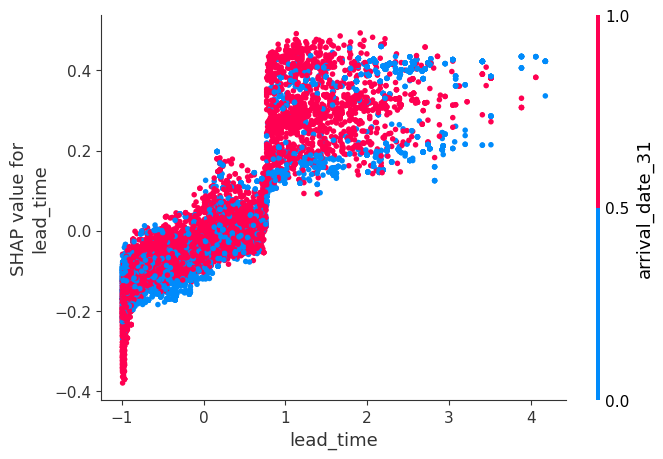

In [33]:
shap.dependence_plot("lead_time", train_random_forest_shap_values[1], X_train_enc)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


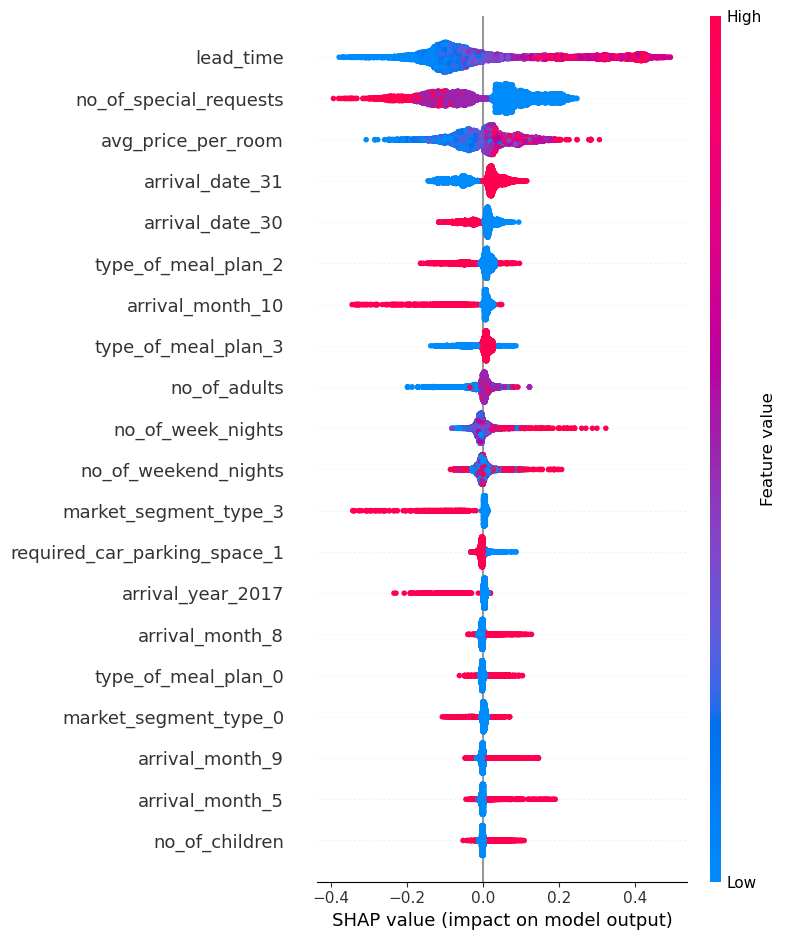

In [34]:
shap.summary_plot(train_random_forest_shap_values[1], X_train_enc)

#### Summary

The most important feature is lead_time, followed by avg_price_per_room and no_of_special_requests.\
Lower values of lead_time have smaller SHAP values for class "canceled", and higher values of lead_time have higher SHAP values for class "canceled".

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

#### Test score

In [35]:
#From lecture 9
from sklearn.metrics import classification_report
model_rf = random_search.best_estimator_
model_rf.fit(X_train, y_train)
print(
    classification_report(
        y_test, model_rf.predict(X_test), target_names=["not canceled", "canceled"]
    )
)

              precision    recall  f1-score   support

not canceled       0.89      0.94      0.91      2365
    canceled       0.88      0.78      0.83      1263

    accuracy                           0.89      3628
   macro avg       0.88      0.86      0.87      3628
weighted avg       0.89      0.89      0.88      3628



In [36]:
f1_score(y_test, model_rf.predict(X_test))

0.8264324550397322

#### Validation score

In [37]:
results["Random forest new"]

fit_time       1.075 (+/- 0.037)
score_time     0.024 (+/- 0.003)
test_score     0.824 (+/- 0.012)
train_score    0.976 (+/- 0.002)
dtype: object

The test score is around 0.826 and the validation score is 0.824. The test score agrees with the validation score from before.\
I think I can trust the result because the test score and the validation score are pretty much the same, and the dataset we are using is fairly large.\
I don't think I've had issues with optimization bias because the test score and the validation score are pretty close, which means we are not overfitting the validation set.

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

In [38]:
results_final = results
results_final["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results_final).T

fit_time         score_time  \
Logistic Regression      0.086 (+/- 0.004)  0.005 (+/- 0.001)   
Logistic Regression new  0.058 (+/- 0.004)  0.005 (+/- 0.001)   
Decision tree            0.099 (+/- 0.003)  0.005 (+/- 0.000)   
Random forest            1.993 (+/- 0.087)  0.037 (+/- 0.001)   
SVC                      1.929 (+/- 0.030)  0.347 (+/- 0.010)   
XGBoost                  0.296 (+/- 0.006)  0.008 (+/- 0.001)   
Random forest new        1.075 (+/- 0.037)  0.024 (+/- 0.003)   
Dummy                    0.001 (+/- 0.000)  0.001 (+/- 0.000)   

                                test_score        train_score  
Logistic Regression      0.703 (+/- 0.010)  0.706 (+/- 0.003)  
Logistic Regression new  0.705 (+/- 0.011)  0.706 (+/- 0.004)  
Decision tree            0.777 (+/- 0.011)  0.994 (+/- 0.001)  
Random forest            0.819 (+/- 0.014)  0.994 (+/- 0.001)  
SVC                      0.750 (+/- 0.011)  0.781 (+/- 0.001)  
XGBoost                  0.812 (+/- 0.005)  0.901 (+/- 0.003)  
Random forest new        0.824 (+/- 0.012)  0.976 (+/- 0.002)  
Dummy                    0.329 (+/- 0.017)  0.321 (+/- 0.006)

1. The final test score on the test set is around 0.826, and the metric I used is the f1 score.
2. All of the models have a higher validation score than the baseline. The best performing model is the tuned random forest, with a validation score of 0.824, and it aligns with the test score of 0.826. The most important feature in the model is lead_time, followed by avg_price_per_room, and this agrees with the initial thought I had at the beginning of the project.
3. First, we could improve our hyperparameter optimization process, we only tuned the hyperparameters for the random forest model because it's the best performing model. If we have more time, we could carry out the optimization process for other models as well. Second, for year, month, and date features, we treated them as categorical variables, but I think we could do some feature engineering or use time series to handle these features. Third, we could try more models such as lgbm.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 